In [3]:
from brian2 import *
%matplotlib inline

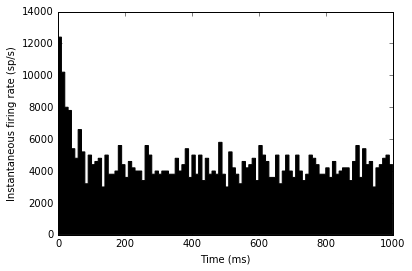

In [4]:
start_scope()

N = 50
tau = 10*ms
vr = -70*mV
vt0 = -50*mV
delta_vt0 = 5*mV
tau_t = 100*ms
sigma = 0.5*(vt0-vr)
v_drive = 2*(vt0-vr)
duration = 1000*ms

eqs = '''
dv/dt = (v_drive+vr-v)/tau + sigma*xi*tau**-0.5 : volt
dvt/dt = (vt0-vt)/tau_t : volt
'''

reset = '''
v = vr
vt += delta_vt0
'''

G = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')
spikemon = SpikeMonitor(G)

G.v = 'rand()*(vt0-vr)+vr'
G.vt = vt0

run(duration)

_ = hist(spikemon.t/ms, 100, histtype='stepfilled', facecolor='k', weights=ones(len(spikemon))/(N*defaultclock.dt))
xlabel('Time (ms)')
ylabel('Instantaneous firing rate (sp/s)');

In [13]:
np.array(spikemon.i)

array([  2,  54, 112, ..., 106, 152, 600], dtype=int32)

In [21]:
import pandas as pd

spikes = pd.DataFrame({'Cluster': np.array(spikemon.i), 'time_samples': np.array(spikemon.t)})

In [22]:
spikes

,Cluster,time_samples
0,5,0.0001
1,37,0.0003
2,17,0.0004
3,2,0.0005
4,39,0.0005
5,8,0.0007
6,10,0.0007
7,26,0.0008
8,31,0.0010
9,6,0.0012


In [14]:
import sys
sys.path.append('../resonnant')
import resonnant as rs
reload(rs)
import pandas as pd

# Test brian2ephys

In [20]:
brianTri = [spikemon, spikemon]
stims = ['teststim', 'teststim']
trialLen = 1.0
iti = 5.0
fs = 20000
(spikes, trials) = rs.brian2ephys(brianTri, stims, trialLen, iti, fs)
clusters = pd.DataFrame({'cluster': range(50), 'quality': 50*['Good']})

In [21]:
import neuraltda.topology as tp
reload(tp)

<module 'neuraltda.topology' from '/Users/brad/GentnerLab/code/NeuralTDA/neuraltda/topology.pyc'>

# Test binning Brian2 output

In [22]:
ncellsperm = 30
nperms = 20
nshuffs = 1
bfdict = tp.do_dag_bin('../',spikes, trials, clusters, fs, 25.0, {'period': 1}, ncellsperm, nperms, nshuffs)